In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append('..')
sys.path.append('../../')
sys.path.append('../data_processing/')
sys.path.append('../model/')
sys.path.append('../model/utils/')
sys.path.append('../model/EGNN_backbone')

In [3]:
import numpy as np
from torch_geometric.loader import DataLoader
import torch
import torch.nn.functional as F
from omegaconf import OmegaConf
from rdkit import Chem
from rdkit.Chem.rdForceFieldHelpers import UFFOptimizeMolecule
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib
import matplotlib.pylab as plt

In [4]:
%matplotlib inline

In [5]:
from data_processing.paired_data import PharmacophoreDataset, CombinedGraphDataset, CombinedSparseGraphDataset
from data_processing.reconstruction import get_atomic_number_from_index, is_aromatic_from_index, reconstruct_from_generated

In [6]:
from model.pp_bridge import PPBridge
from model.pp_bridge_sampler import PPBridgeSampler
from model.utils.utils_diffusion import center2zero_combined_graph, center2zero_with_mask, center2zero

In [7]:
from script_utils import load_data
from evaluation.utils import build_pdb_dict

In [8]:
# init with fixed points
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-05-30_23_27_53.688104' # only basic
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-05-31_14_11_45.077216' # support aromatic

# init with standard gaussian noise
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-06-17_23_06_28.209248' # only basic
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-06-17_23_04_23.779433' # support aromatic

# CE loss
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-02_02_43_48.858042' # only basic
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-02_02_44_27.850031' # support aromatic

# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-14_11_41_42.887999'
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-13_20_17_47.526432'
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-13_20_54_21.154940'
model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-16_14_16_52.051160'

basic_mode = False

In [9]:
config_file = os.path.join(model_root, 'vp_bridge_egnn.yml')
# config_file = '../../src/config/ve_bridge.yml'
config = OmegaConf.load(config_file)
# config.data.aromatic = True
config

{'model': {'denoiser': {'bridge_type': 'vp', 'beta_d': 2, 'beta_min': 0.1, 'schedule_sampler': 'real-uniform', 'use_ema': True, 'ema_decay': 0.999, 'weight_decay': 1e-12, 'weight_schedule': 'bridge_karras', 'loss_x_weight': 10.0}, 'backbone': {'type': 'EGNN', 'feature_size': 12, 'num_layers': 10, 'hidden_size': 128, 'time_cond': True, 'xT_type': 'pp', 'xT_mode': 'concat_graph'}}, 'training': {'batch_size': 200, 'log_interval': 100, 'save_interval': 1000, 'test_interval': 1000, 'total_training_steps': 10000000, 'learning_rate': 0.01, 'lr_anneal_steps': 0, 'max_epochs': 100, 'use_lr_scheduler': True, 'lr_scheduler_config': {'target': 'model.utils.lr_scheduler.LambdaLinearScheduler', 'params': {'warm_up_steps': [10000], 'cycle_lengths': [10000000000000], 'f_start': [1e-06], 'f_max': [1.0], 'f_min': [1.0]}}}, 'sampling': {'batch_size': 2000}, 'data': {'root': '../data/cleaned_crossdocked_data', 'max_node_num': 86, 'coord_dim': 3, 'module': 'CombinedSparseGraphDataset', 'aromatic': True, 'f

In [10]:
# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-05-30_23_27_53.688104/epoch=94-val_loss=2.98.ckpt'
# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-05-31_14_11_45.077216/epoch=98-val_loss=3.15.ckpt'

# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-06-17_23_04_23.779433/epoch=85-val_loss=4.38.ckpt'
# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-06-17_23_06_28.209248/epoch=82-val_loss=4.18.ckpt'

# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-02_02_43_48.858042/epoch=89-val_loss=16.68.ckpt'
# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-02_02_44_27.850031/epoch=72-val_loss=19.98.ckpt'

# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-14_11_41_42.887999/epoch=65-val_loss=2.52.ckpt'
# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-13_20_17_47.526432/epoch=66-val_loss=2.63.ckpt'
# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-13_20_54_21.154940/epoch=97-val_loss=10.04.ckpt'
ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-16_14_16_52.051160/epoch=95-val_loss=37.01.ckpt'
# ckpt = torch.load(ckpt_path)
# ckpt

In [11]:
device = 'cuda:3'

In [12]:
sampler = PPBridgeSampler(config, ckpt_path, device)

Using lr scheduler
Using real uniform sampler
Using lr scheduler
Using real uniform sampler


In [13]:
root = '/home/conghao001/pharmacophore2drug/PP2Drug/data/cleaned_crossdocked_data'
split = 'test'
batch_size = 10
num_workers = 0

In [14]:
# dataset = CombinedGraphDataset(root, split)
# dataset = CombinedSparseGraphDataset(root, split)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

dataset, _ = load_data(config.data.module, root, split=split, batch_size=batch_size, aromatic=config.data.aromatic)

In [15]:
dataloader = DataLoader(dataset[0:10], batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [16]:
len(dataset)

28208

In [17]:
pdb_dict, pdb_rev_dict = build_pdb_dict(root)

In [18]:
one = next(iter(dataloader))
one = one.to(device)
one

DataBatch(x=[352, 12], pos=[352, 3], target_x=[352, 12], target_pos=[352, 3], Gt_mask=[352], ligand_name=[10], batch=[352], ptr=[11])

In [19]:
# for batch in dataloader:
#     if batch.ligand_name[0] == '4ls1_A_rec_5h73_7l7_lig_tt_min_0':
#         one = batch
# one = one.to(device)

In [20]:
one.ligand_name

['3kcz_A_rec_3kcz_3ab_lig_tt_min_0',
 '3kcz_A_rec_3kjd_78p_lig_tt_docked_3',
 '3kcz_A_rec_3kjd_78p_lig_tt_min_0',
 '3kjd_B_rec_3kcz_3ab_lig_tt_min_0',
 '3kjd_B_rec_3kjd_78p_lig_tt_docked_3',
 '3kjd_B_rec_3kjd_78p_lig_tt_min_0',
 '4pjv_A_rec_3kcz_3ab_lig_tt_min_0',
 '4pjv_A_rec_3kjd_78p_lig_tt_min_0',
 '4pjv_A_rec_4pjv_2yq_lig_tt_docked_0',
 '4pjv_A_rec_4pjv_2yq_lig_tt_min_0']

In [21]:
# tmp_mask = one.Gt_mask.view(batch_size, -1)
# one.target_x[0][tmp_mask[0]].size()

In [22]:
# for node_feat in one.target_x[one.Gt_mask]:
#     print(node_feat)

In [23]:
num_nodes = one.x.size(0)
node_mask = torch.ones([1, num_nodes], device=one.x.device, dtype=torch.bool)

In [24]:
xT, hT, Gt_mask, batch_info = sampler.preprocess(one.target_pos, one.target_x, node_mask=node_mask, Gt_mask=one.Gt_mask, batch_info=one.batch, device=device)

In [25]:
xT.size()

torch.Size([352, 3])

In [26]:
hT

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]], device='cuda:3')

In [27]:
Gt_mask.size()

torch.Size([352])

## Important
***sigma min and max values***
differ for ve/vp bridges!!!

In [28]:
steps = 500
# x, x_traj, h, h_traj, nfe = sampler.sample(one.target_pos, one.target_x, steps, node_mask=one.node_mask, Gt_mask=one.Gt_mask, batch_info=one.batch, churn_step_ratio=0.33, device=device)
x, x_traj, h, h_traj, nfe = sampler.sample(one.target_pos, one.target_x, steps, node_mask=node_mask, Gt_mask=one.Gt_mask, batch_info=one.batch, sigma_min=0.001, sigma_max=1, churn_step_ratio=0.33, device=device)

nfe: 1499


In [29]:
print(x.size(), x[Gt_mask].size())

torch.Size([352, 3]) torch.Size([176, 3])


In [30]:
one.batch.size()

torch.Size([352])

In [31]:
num_graphs = max(one.batch).item() + 1
num_graphs

10

In [32]:
i = 0
index_i = one.batch==i
index_i.sum()

tensor(20, device='cuda:3')

In [33]:
# x_i = x[Gt_mask][index_i]
x_i = x[index_i][Gt_mask[index_i]]
x_i.size()

torch.Size([10, 3])

In [34]:
Gt_mask.device

device(type='cuda', index=3)

In [35]:
x_traj_i = [xt[index_i.cpu()][Gt_mask[index_i].cpu()] for xt in x_traj]
x_traj_i

[tensor([[ 1.2568,  0.9362,  2.4373],
         [ 0.4251, -0.5140,  0.2772],
         [ 0.4260, -0.5313,  0.2966],
         [ 0.4357, -0.5150,  0.2867],
         [ 0.4373, -0.5175,  0.2962],
         [ 0.4342, -0.5103,  0.2736],
         [ 0.4408, -0.5238,  0.2643],
         [-0.2003,  0.0963, -0.1945],
         [-2.0850,  0.0418, -2.4271],
         [-1.5705,  2.0376, -1.5103]], device='cuda:3'),
 tensor([[ 1.1922,  1.0001,  2.4327],
         [ 0.3894, -0.5509,  0.2660],
         [ 0.3181, -0.4167,  0.2567],
         [ 0.4712, -0.5048,  0.3576],
         [ 0.3255, -0.5324,  0.3486],
         [ 0.4461, -0.4743,  0.1563],
         [ 0.5421, -0.4772,  0.2686],
         [-0.2063,  0.2291, -0.2340],
         [-2.1302,  0.0289, -2.4976],
         [-1.5445,  2.0921, -1.4361]]),
 tensor([[ 1.1408,  1.0511,  2.4265],
         [ 0.3599, -0.5810,  0.2565],
         [ 0.2301, -0.3235,  0.2236],
         [ 0.4997, -0.4967,  0.4149],
         [ 0.2346, -0.5445,  0.3902],
         [ 0.4550, -0.4453,  

In [36]:
len(x_traj_i)

1001

In [37]:
len(x_traj)

1001

In [38]:
x_traj_i[0].size()

torch.Size([10, 3])

In [39]:
x_traj[0].size()

torch.Size([352, 3])

In [40]:
x_i

tensor([[ 0.2201,  1.6006,  0.7956],
        [-2.0499,  0.4990, -1.1054],
        [-1.0538, -1.4603,  0.3514],
        [ 1.0443,  0.5376, -0.6126],
        [-1.0642, -1.8173, -0.7470],
        [ 0.4049, -0.7355, -1.3679],
        [ 0.0723,  0.9475, -1.7966],
        [-1.0854,  1.7581, -1.4776],
        [-1.6283, -0.2335, -1.9879],
        [-1.6857,  0.5960, -1.5690]], device='cuda:3')

In [41]:
x_i_arr = x_i.cpu().numpy()

x_i_arr[:, 0]

array([ 0.22009642, -2.049877  , -1.0537528 ,  1.0443174 , -1.0641552 ,
        0.4049334 ,  0.07226917, -1.0854108 , -1.6283131 , -1.6856967 ],
      dtype=float32)

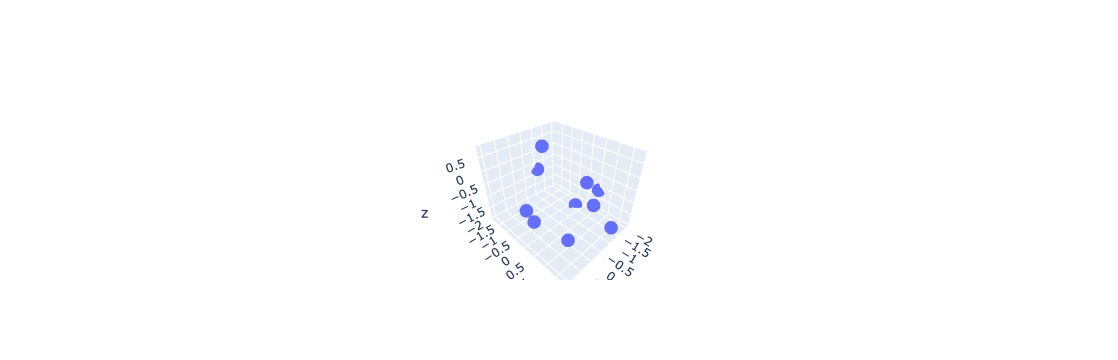

In [42]:
fig = go.Figure(data=[go.Scatter3d(x=x_i_arr[:, 0], y=x_i_arr[:, 1], z=x_i_arr[:, 2],
                                   mode='markers')])
fig.show()

In [43]:
xt_sampled = [x_traj_i[i] for i in range(len(x_traj_i)) if i%80==0]
len(xt_sampled)

13

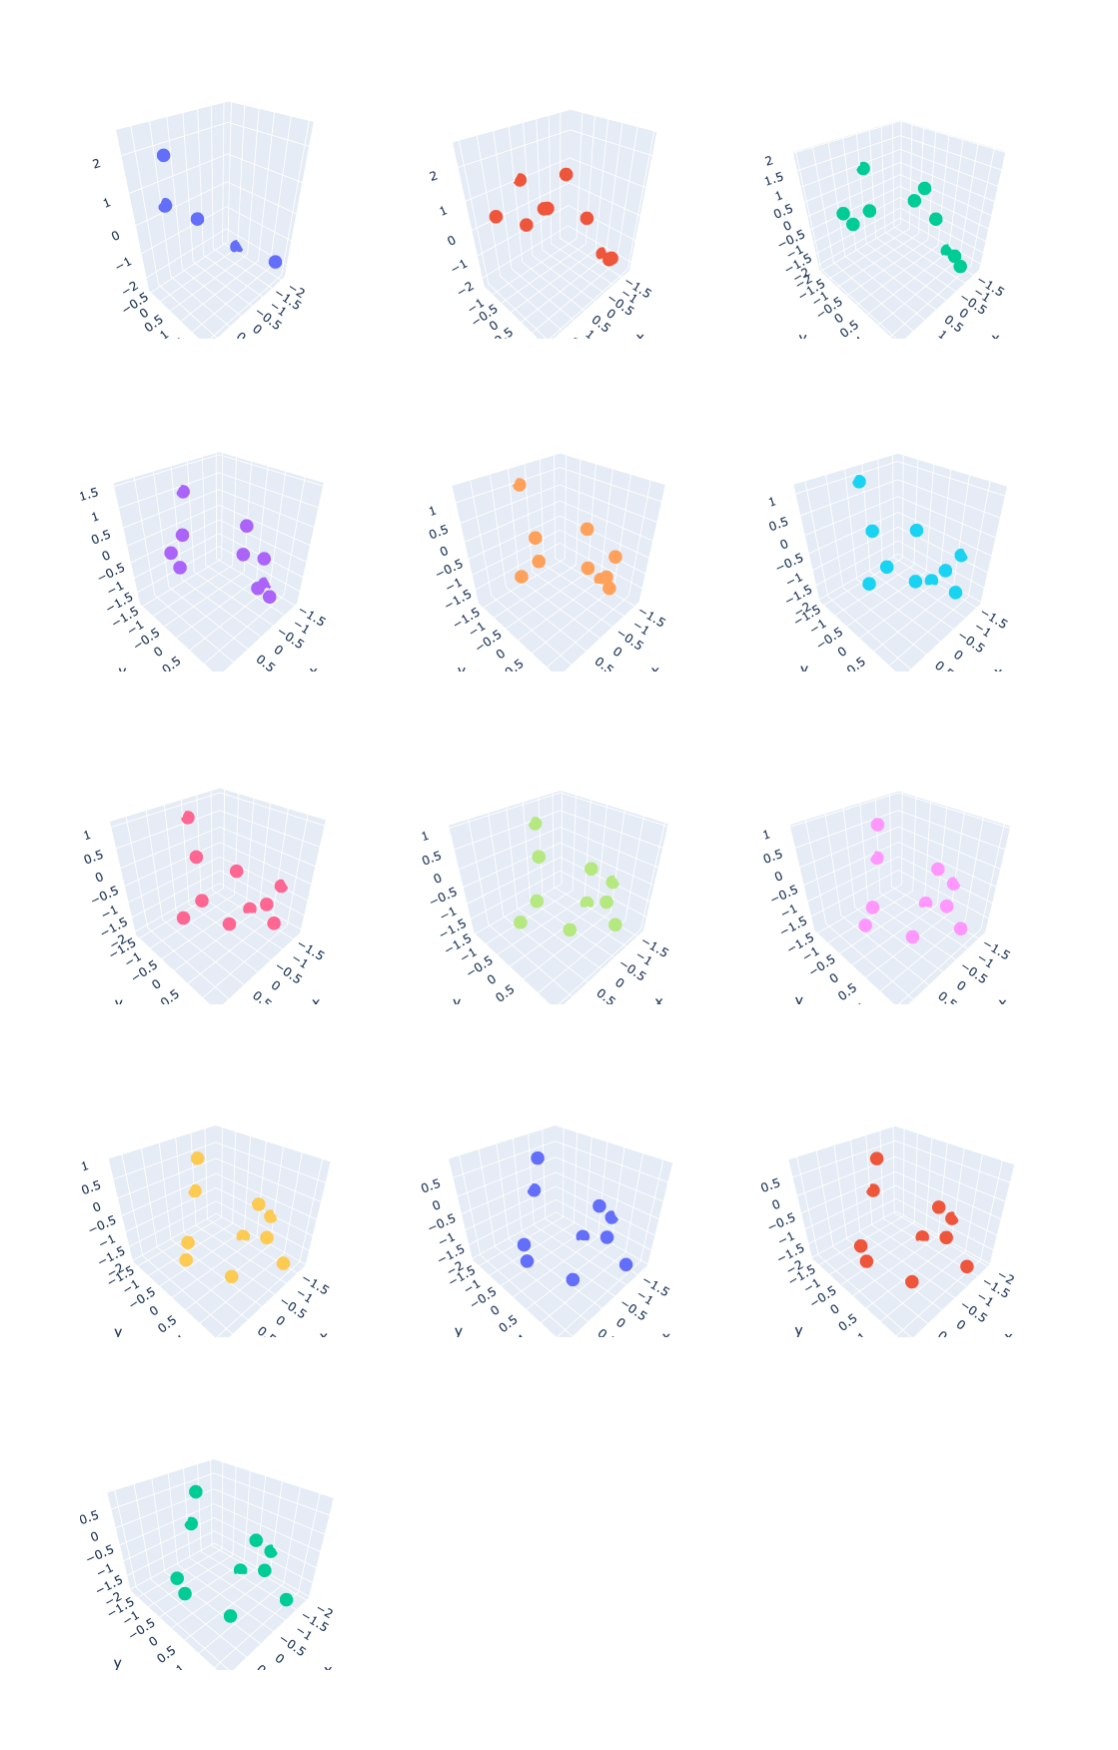

In [44]:
nc = 3
nr = len(xt_sampled)//nc + 1
fig = make_subplots(rows=nr, cols=nc, 
                   specs = [[{"type": "scatter3d"} for i in range(nc)] for i in range(nr)]
                   )

for i in range(len(xt_sampled)):
    arr = xt_sampled[i].cpu().numpy()
    fig.add_trace(
        go.Scatter3d(x=arr[:, 0], y=arr[:, 1], z=arr[:, 2], mode='markers'),
        row=i//nc + 1, col=i%nc + 1
    )

fig.update_layout(height=nr*350, showlegend=False)
fig.show()

In [45]:
# one.original_pos
original_pos_i = one.pos[index_i][Gt_mask[index_i]]
original_pos_0center_i = center2zero(original_pos_i)
original_pos_0center_i.size()

torch.Size([10, 3])

In [46]:
original_pos_0center_i_arr = original_pos_0center_i.cpu().numpy()

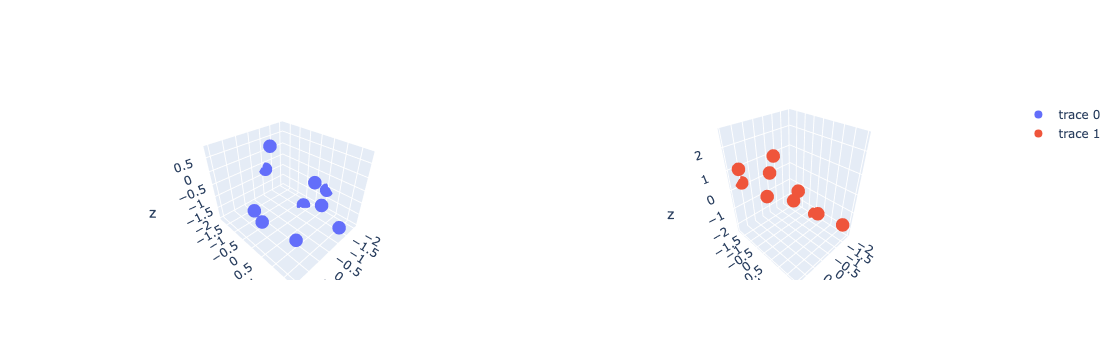

In [47]:
fig = make_subplots(rows=1, cols=2, 
                   specs = [[{"type": "scatter3d"} for i in range(2)]]
                   )


fig.add_trace(
    go.Scatter3d(x=x_i_arr[:, 0], y=x_i_arr[:, 1], z=x_i_arr[:, 2], mode='markers'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter3d(x=original_pos_0center_i_arr[:, 0], y=original_pos_0center_i_arr[:, 1], z=original_pos_0center_i_arr[:, 2], mode='markers'),
    row=1, col=2
)

# fig.update_layout(height=500, showlegend=False)
fig.show()

In [48]:
one.pos.size()

torch.Size([352, 3])

In [49]:
h_i = h[index_i][Gt_mask[index_i]]
h_i.size()

torch.Size([10, 12])

In [50]:
h_i

tensor([[ 9.3416e-02,  6.1933e-02,  8.1474e-01, -8.6648e-03,  5.4507e-03,
         -2.3074e-02, -1.6823e-03, -6.0212e-03, -1.7335e-02, -2.3154e-02,
         -1.6709e-02,  1.1458e-03],
        [ 2.3842e-01,  8.2574e-01, -2.4771e-02, -2.1396e-02, -1.8185e-02,
         -4.6568e-02,  4.8049e-02, -1.2043e-02, -1.4640e-03, -2.1991e-02,
         -3.9134e-02,  8.3663e-04],
        [ 1.0035e-01,  9.3106e-01, -2.0774e-02, -1.0038e-02,  9.3115e-03,
         -4.0107e-02,  7.7012e-03, -9.6981e-03, -2.6696e-02, -1.6401e-02,
         -1.4320e-02,  3.2939e-03],
        [ 1.0653e+00, -1.6266e-02, -7.5808e-03, -1.5263e-02, -1.3097e-02,
         -4.0310e-02,  1.5947e-02, -1.5214e-02,  1.0488e-04,  5.8646e-03,
         -1.1994e-02,  1.6435e-02],
        [ 2.0297e-01,  2.1147e-01,  6.3984e-01,  1.2036e-02, -2.0743e-02,
         -3.7697e-02, -1.7636e-02,  4.0489e-03, -5.9472e-03, -1.7317e-02,
         -2.6966e-02, -5.0407e-03],
        [ 8.9440e-02,  3.4846e-01,  6.1720e-01, -2.3017e-02,  6.6594e-03,
      

In [51]:
h_traj_i = [xt[index_i.cpu()][Gt_mask[index_i].cpu()] for xt in x_traj]

In [52]:
# torch.argmax(one.x[i], dim=-1)
torch.argmax(one.x, dim=-1)

tensor([2, 1, 1, 1, 1, 1, 1, 0, 4, 2, 5, 2, 2, 2, 2, 2, 2, 0, 6, 5, 1, 1, 1, 1,
        1, 1, 1, 3, 3, 0, 0, 0, 2, 0, 0, 0, 2, 4, 2, 2, 2, 0, 2, 2, 2, 0, 5, 0,
        0, 1, 5, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 3, 3, 0, 0, 0, 2, 0, 0, 0,
        2, 4, 2, 2, 2, 0, 2, 2, 2, 6, 0, 0, 0, 0, 5, 0, 1, 0, 0, 6, 2, 1, 1, 1,
        1, 1, 1, 0, 4, 2, 5, 2, 2, 2, 2, 2, 2, 0, 0, 5, 1, 1, 1, 1, 1, 1, 1, 3,
        3, 0, 0, 0, 2, 0, 0, 0, 2, 4, 2, 2, 2, 0, 2, 2, 2, 6, 5, 0, 0, 1, 5, 1,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 3, 3, 0, 0, 0, 2, 0, 0, 0, 2, 4, 2, 2,
        2, 0, 2, 2, 2, 6, 5, 0, 0, 0, 5, 0, 0, 0, 5, 6, 2, 1, 1, 1, 1, 1, 1, 0,
        4, 2, 5, 2, 2, 2, 2, 2, 2, 0, 6, 5, 1, 1, 1, 1, 1, 1, 1, 3, 3, 0, 0, 0,
        2, 0, 0, 0, 2, 4, 2, 2, 2, 0, 2, 2, 2, 0, 5, 0, 0, 1, 5, 1, 0, 0, 0, 0,
        3, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 6, 1, 4, 3, 1, 1, 6, 1, 1, 1, 1, 1, 3,
        1, 3, 3, 0, 2, 0, 2, 1, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 7, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 0, 3, 2, 1,

In [53]:
# h = F.softmax(h, dim=-1)
h_class = torch.argmax(h_i, dim=-1)
h_class

tensor([2, 1, 1, 0, 2, 2, 2, 2, 1, 1], device='cuda:3')

In [54]:
h_onehot = torch.nn.functional.one_hot(h_class, num_classes=13)
h_onehot

tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:3')

In [55]:
atom_index = h_class.detach().cpu()
if h_onehot.size(-1) == 8:
    index_to_atom_type = MAP_ATOMIC_NUMBER_TO_INDEX
    atom_type = get_atomic_number_from_index(atom_index, index_to_atom_type=index_to_atom_type_aromatic)
else:
    atom_type = get_atomic_number_from_index(atom_index)
atom_type

[7, 6, 6, 6, 7, 7, 7, 7, 6, 6]

In [56]:
if basic_mode:
    atom_aromatic = None
else:
    atom_aromatic = is_aromatic_from_index(atom_index)
atom_aromatic

[False, True, True, False, False, False, False, False, True, True]

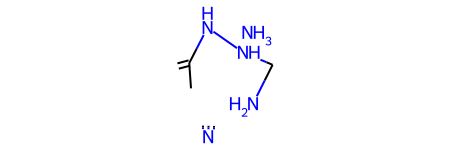

In [57]:
pos = x_i.detach().cpu().tolist()
mol = reconstruct_from_generated(pos, atom_type, atom_aromatic, basic_mode)
mol

[02:41:00] Molecule does not have explicit Hs. Consider calling AddHs()


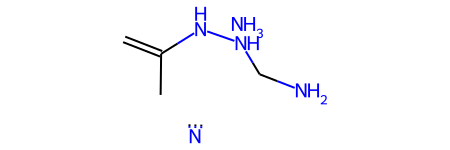

In [58]:
# mol = Chem.AddHs(mol, addCoord=True)
UFFOptimizeMolecule(mol)
mol

In [59]:
# this is for aromatic!!! not basic mode!!!

mols = []
for i in range(num_graphs):
    index_i = one.batch==i
    x_i = x[index_i][Gt_mask[index_i]]
    h_i = h[index_i][Gt_mask[index_i]]
    h_class = torch.argmax(h_i, dim=-1)
    atom_index = h_class.detach().cpu()
    atom_type = get_atomic_number_from_index(atom_index)
    atom_aromatic = is_aromatic_from_index(atom_index)
    pos = x_i.detach().cpu().tolist()
    try:
        mol = reconstruct_from_generated(pos, atom_type, atom_aromatic, basic_mode)
        mols.append(mol)
    except:
        continue

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders



In [60]:
len(mols)

10

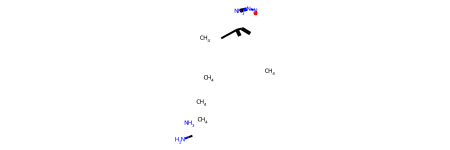

In [62]:
example = mols[1]
example

[02:41:24] Molecule does not have explicit Hs. Consider calling AddHs()


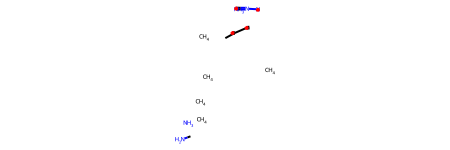

In [63]:
# example = Chem.AddHs(example, addCoord=True)
UFFOptimizeMolecule(example)
example

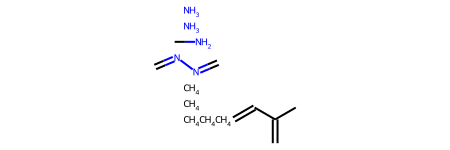

In [64]:
m = Chem.MolFromSmiles(Chem.MolToSmiles(example))
m

In [65]:
# with Chem.SDWriter('generated_example.sdf') as w:
#   w.write(m)